In [1]:
import pandas as pd
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
%matplotlib inline

In [151]:
def sam_to_table(code):
    read_table = defaultdict(int)
    with open(f"{code}/Aligned.out.sam") as inpfile:
        for line in inpfile:
            if line.startswith('@'): continue # header 제거
        
            line_list = line.split()
            if line_list[1]==4: continue # 잘못 read된 data 제거
        
            if line_list[2].startswith('ENSMUST'):
                read_table[line_list[2].split('|')[0]]+=1
            
    table_df = pd.Series(read_table)
    return table_df[table_df>= 30] # 30 read 보다 작은 경우는 filter

In [152]:
table = sam_to_table("RPF_siLin28a")
table.head()

ENSMUST00000240377.1    1007005
ENSMUST00000116560.3       1341
ENSMUST00000209469.2       1377
ENSMUST00000237122.2       1335
ENSMUST00000236645.2       1002
dtype: int64

In [141]:
table = table.sort_values(ascending=False)
table.head()
len(table)

9574

In [119]:
path = "/home/qbio1/kangjunseo/tutorials/ref_gene/gencode.vM29.primary_assembly.annotation.gtf"

In [31]:
def read_specific_transcript(code, trans):
    read_table = defaultdict(int)
    with open(f"{code}/Aligned.out.sam") as inpfile:
        for line in inpfile:
            if line.startswith('@'): continue # header 제거
            
            line_list = line.split()
            if line_list[1]==4: continue # 잘못 read된 data 제거
        
            if line_list[2].startswith(trans):
                read_table[int(line_list[3])]+=1
            
    table_df = pd.Series(read_table)
    return table_df

In [250]:
RST = read_specific_transcript("RPF_siLin28a","ENSMUST00000239545.1")
RST.head()

3434    1
dtype: int64

In [251]:
RST.sort_values(ascending=False).head()

3434    1
dtype: int64

<AxesSubplot:>

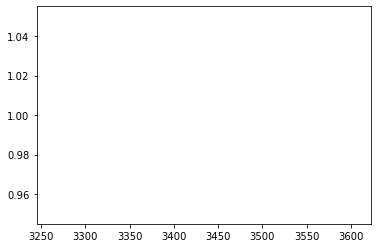

In [252]:
RST = RST.sort_index()
RST.plot()

In [46]:
table2 = sam_to_table("RPF_siLuc")
table2.head()

ENSMUST00000082390.1       25977
ENSMUST00000044200.11        707
ENSMUST00000204185.2         288
ENSMUST00000058030.10        780
ENSMUST00000240377.1     6432837
dtype: int64

In [47]:
table2.sort_values(ascending=False).head()

ENSMUST00000240377.1     6432837
ENSMUST00000082402.1       63193
ENSMUST00000024739.14      62942
ENSMUST00000094361.11      61914
ENSMUST00000021698.13      59815
dtype: int64

In [57]:
RST2 = read_specific_transcript("RPF_siLuc","ENSMUST00000240377.1")
RST2.sort_index().head()

1    2148
2     113
3      56
4      24
5      31
dtype: int64

1848


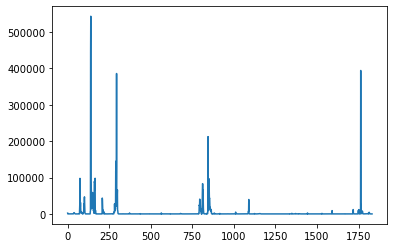

In [56]:
RST2.sort_index()[:].plot()
print(9092-7244)

## 1.GTF File Parsing

### Informations we need
- column 3 : feature type
- column 4 : genomic start loc
- column 5 : genomic end loc
- column 7 : genomic strand(+/-)
- column 9 : additional info
    - gene_id
    - transcript_id
    - gene_type
    - level
    
### Filtering
- non coding genes
- gene level not 1
- (+) strand

In [182]:
GTF_df = pd.read_csv(path, header=5, delimiter='\t')
GTF_df.columns=['chr','ann','feature','start','end','score','strand','phase','add']
GTF_df.head()

,chr,ann,feature,start,end,score,strand,phase,add
0,chr1,HAVANA,transcript,3143476,3144545,.,+,.,"gene_id ""ENSMUSG00000102693.2""; transcript_id ..."
1,chr1,HAVANA,exon,3143476,3144545,.,+,.,"gene_id ""ENSMUSG00000102693.2""; transcript_id ..."
2,chr1,ENSEMBL,gene,3172239,3172348,.,+,.,"gene_id ""ENSMUSG00000064842.3""; gene_type ""snR..."
3,chr1,ENSEMBL,transcript,3172239,3172348,.,+,.,"gene_id ""ENSMUSG00000064842.3""; transcript_id ..."
4,chr1,ENSEMBL,exon,3172239,3172348,.,+,.,"gene_id ""ENSMUSG00000064842.3""; transcript_id ..."


In [185]:
GTF_df_compact = GTF_df.drop(columns=['chr','ann','score','phase'])
GTF_df_compact.head()

,feature,start,end,strand,add
0,transcript,3143476,3144545,+,"gene_id ""ENSMUSG00000102693.2""; transcript_id ..."
1,exon,3143476,3144545,+,"gene_id ""ENSMUSG00000102693.2""; transcript_id ..."
2,gene,3172239,3172348,+,"gene_id ""ENSMUSG00000064842.3""; gene_type ""snR..."
3,transcript,3172239,3172348,+,"gene_id ""ENSMUSG00000064842.3""; transcript_id ..."
4,exon,3172239,3172348,+,"gene_id ""ENSMUSG00000064842.3""; transcript_id ..."


In [203]:
def parse_add(add):
    ret_dict = {'transcript_id':'NaN'}
    valid = ['gene_id','transcript_id','gene_type','gene_name','level']
    for row in add.split(';'):
        kv_pair = row.split()
        if len(kv_pair)<=1 : continue
        if kv_pair[0] in valid:
            ret_dict[kv_pair[0]]=kv_pair[1]
    return [val.replace('"','') for val in ret_dict.values()]

In [226]:
add_table = []
for row in GTF_df['add']:
    add_table.append(parse_add(row))
add_df = pd.DataFrame(add_table)
add_df.head()

,0,1,2,3,4
0,ENSMUST00000193812.2,ENSMUSG00000102693.2,TEC,4933401J01Rik,2
1,ENSMUST00000193812.2,ENSMUSG00000102693.2,TEC,4933401J01Rik,2
2,NaN,ENSMUSG00000064842.3,snRNA,Gm26206,3
3,ENSMUST00000082908.3,ENSMUSG00000064842.3,snRNA,Gm26206,3
4,ENSMUST00000082908.3,ENSMUSG00000064842.3,snRNA,Gm26206,3


In [234]:
GTF_df2 = pd.concat([GTF_df_compact,add_df], axis=1)
GTF_df2 = GTF_df2.drop(columns=['add'])
GTF_df2.columns = ['feature','start','end','strand','transcript_id','gene_id','gene_type','gene_name','level']
GTF_df2.head()

,feature,start,end,strand,transcript_id,gene_id,gene_type,gene_name,level
0,transcript,3143476,3144545,+,ENSMUST00000193812.2,ENSMUSG00000102693.2,TEC,4933401J01Rik,2
1,exon,3143476,3144545,+,ENSMUST00000193812.2,ENSMUSG00000102693.2,TEC,4933401J01Rik,2
2,gene,3172239,3172348,+,NaN,ENSMUSG00000064842.3,snRNA,Gm26206,3
3,transcript,3172239,3172348,+,ENSMUST00000082908.3,ENSMUSG00000064842.3,snRNA,Gm26206,3
4,exon,3172239,3172348,+,ENSMUST00000082908.3,ENSMUSG00000064842.3,snRNA,Gm26206,3


In [236]:
GTF_df2 = GTF_df2[GTF_df2['gene_type']=='protein_coding']
GTF_df2 = GTF_df2[(GTF_df2['level']=='1')|(GTF_df2['level']=='2')]
GTF_df2['length'] = GTF_df2['end']-GTF_df2['start']+1

,feature,start,end,strand,transcript_id,gene_id,gene_type,gene_name,level,length
5,gene,3276124,3741721,-,NaN,ENSMUSG00000051951.6,protein_coding,Xkr4,2,465598
6,transcript,3276124,3286567,-,ENSMUST00000162897.2,ENSMUSG00000051951.6,protein_coding,Xkr4,2,10444
7,exon,3283832,3286567,-,ENSMUST00000162897.2,ENSMUSG00000051951.6,protein_coding,Xkr4,2,2736
8,exon,3276124,3277540,-,ENSMUST00000162897.2,ENSMUSG00000051951.6,protein_coding,Xkr4,2,1417
9,transcript,3276746,3285855,-,ENSMUST00000159265.2,ENSMUSG00000051951.6,protein_coding,Xkr4,2,9110


In [237]:
GTF_df2_plus = GTF_df2[GTF_df2['strand']=='+']
GTF_df2_plus.head()

,feature,start,end,strand,transcript_id,gene_id,gene_type,gene_name,level,length
354,gene,4878011,4918633,+,NaN,ENSMUSG00000025903.15,protein_coding,Lypla1,2,40623
355,transcript,4878011,4918633,+,ENSMUST00000134384.8,ENSMUSG00000025903.15,protein_coding,Lypla1,2,40623
356,exon,4878011,4878205,+,ENSMUST00000134384.8,ENSMUSG00000025903.15,protein_coding,Lypla1,2,195
357,CDS,4878137,4878205,+,ENSMUST00000134384.8,ENSMUSG00000025903.15,protein_coding,Lypla1,2,69
358,start_codon,4878137,4878139,+,ENSMUST00000134384.8,ENSMUSG00000025903.15,protein_coding,Lypla1,2,3


In [238]:
GTF_df2_plus_CDS = GTF_df2_plus[GTF_df2_plus['feature']=='CDS']
GTF_df2_plus_CDS.head()

,feature,start,end,strand,transcript_id,gene_id,gene_type,gene_name,level,length
357,CDS,4878137,4878205,+,ENSMUST00000134384.8,ENSMUSG00000025903.15,protein_coding,Lypla1,2,69
360,CDS,4878678,4878709,+,ENSMUST00000134384.8,ENSMUSG00000025903.15,protein_coding,Lypla1,2,32
362,CDS,4898807,4898872,+,ENSMUST00000134384.8,ENSMUSG00000025903.15,protein_coding,Lypla1,2,66
364,CDS,4900491,4900538,+,ENSMUST00000134384.8,ENSMUSG00000025903.15,protein_coding,Lypla1,2,48
366,CDS,4902534,4902604,+,ENSMUST00000134384.8,ENSMUSG00000025903.15,protein_coding,Lypla1,2,71


In [239]:
GTF_df2_plus_CDS[['transcript_id','length']].groupby(by=['transcript_id']).sum().sort_values(by=['length'], ascending=False)

,length
transcript_id,
ENSMUST00000183034.5,23151
ENSMUST00000239545.1,22572
ENSMUST00000097785.10,22179
ENSMUST00000143764.9,20985
ENSMUST00000143031.8,20610
...,...
ENSMUST00000201484.4,3
ENSMUST00000140136.9,3
ENSMUST00000202527.4,3
